# Sayısal Sistemlere Giriş

<a href="https://colab.research.google.com/drive/1CJfeuQTUlCuWf0DpUDA3NFzIt2dsC4Lw?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sayısal Sistemlere Giriş

**Önemli not:** Bu defterin içeriği mühendislik öğrencileri/mezunlarına yönelik hazırlanmıştır. Bu alanda deneyiminiz yok ise içerik sizin için yorucu olabilir. Bu durumda 2. ve 3. defterleri atlayıp "Sinyallerin frekans spektrum analizi" başlıklı 4. defterden okumaya devam edebilirsiniz. 

Bu defterimizde amacımız sayısal sinyalleri girdi olarak alıp işleyen ve sayısal çıktı sunan sistemlere örnekler sunmaktır. En basitinden başlayarak bazı sistemleri ele alacak, Python ile kodlayacak ve bu sistemlerin karakteristiklerini inceleyeceğiz. 

Sistemler verilen bir girdiye karşılık bir çıktı üreten yapılar olarak ele alanabilir ve sıklıkla Şekilde 2.1'deki gibi bir kutu ile temsil edilir. Bu çizimde üstte sürekli zaman (analog işaret ve sistem), altta ayrık zaman (sayısal işaret ve sistem) temsil edilmiştir.  

|         <img src="https://www.probabilitycourse.com/images/chapter10/LTI.png" width=400 height=200 />          |
| :------------------------------------------------------------------------------------------------------------: |
| Şekil 2.1: _Sistemler: üst grafik) sürekli zamanda bir sistem, alt grafik) ayrık zamanda bir (sayısal) sistem_ |


Şekilde kutu içerisinde belirtilen $h(t)$ (veya $h[n]$) sistemin bir dürtü(*impulse*) girdiye karşılık ürettiği çıktıyı temsil etmektedir. 

$$h[n] = f(\delta[n])$$

Buna dürtü cevabı([*impulse response*](https://en.wikipedia.org/wiki/Impulse_response#:~:text=In%20signal%20processing%2C%20the%20impulse,response%20to%20some%20external%20change.)) ismi verildiğini önceki defterimizde belirtmiştik.


Sistemlerimiz doğrusal ve zamanla değişmiyor (İng: [linear time invariant](https://en.wikipedia.org/wiki/Linear_time-invariant_system), LTI) ve sistemin dürtü cevabı ($h(t)$ veya $h[n]$) biliniyor ise herhangi bir girdi sinyaline karşılık sistemin oluşturacağı çıktı sinyali ($y(t)$ veya $y[n]$) konvolüsyon işlemi ile hesaplanabilir ($y[n] = h[n] \circledast x[n]$). Bu işlemi de bir önceki defterimizde ele almıştık. 



Sistemleri kod yazarak oluşturmak (bir bilgisayar programı olarak gerçeklemek) istediğimizde genellikle önümüzde dört olası yöntem bulunmaktadır:

*   Tanımdan yola çıkarak hedeflenen sonucu temel vektör işlemleriyle veya döngüler yardımıyla gerçekleştiren bir fonksiyon yazmak  
*   Dürtü cevabını kullanarak konvolüsyon işlemi ile çıktıyı hesaplatmak
*   Sistemin frekans cevabını polinomlarla temsil etmek ve hazır sinyal işleme kütüphanesi fonksiyonlarını kullanmak (örnek: [scipy.signal.lfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html)) 
*   Sistemi frekans uzayında işlemlerle gerçeklemek

Burada öncelikle ilk iki yöntemi kullanarak bazı basit sistemler için Python fonksiyonları yazacağız. Daha sonra üçüncü ve dördüncü opsiyonlar için örnekler sunacağız.


Öncelikle gerekli kütüphanelerimizi yükleyerek başlayalım:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline
import IPython
from IPython.display import Image
from IPython.core.display import HTML 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Örneklerde kullanacağımız ses dosyasını indirelim
!pip install pysoundfile # Ses dosyalarını okumak için kullanacağımız kütüphane kurulumu
import urllib.request # Dosya indirmek için kullanacağımız kütüphane 
import soundfile as sf # Ses dosyalarını okumak için kullanacağımız kütüphane 

url = 'https://github.com/MTG/sms-tools/raw/master/sounds/speech-male.wav'
urllib.request.urlretrieve(url,'speech-male.wav')

('speech-male.wav', <http.client.HTTPMessage at 0x7ff15adc2950>)

### Basit gecikme sistemi (Simple delay system)

Düşünebileceğimiz en basit sistemlerden birisi giriş sinyalini zamanda öteleyen/geciktiren bir sistemdir. Girdi-çıktı ilişkisi şu denklemle ifade edilebilir:

$$y[n] = f(x[n]) = x[n-n_0]$$

Bu sistem, $x[n]$ girdi sinyalini $n_0$ örnek kadar geciktirecektir. Sistemin dürtü cevabını bulmak istediğimizde $\delta[n]$in girdi olduğu durumda oluşan çıktıyı hesaplayabiliriz:


$$h[n] = f(\delta[n]) = \delta[n-n_0]$$

Şimdi iki yöntem ile bu sayısal sistemi gerçekleyelim. Sistemi temsilen fonksiyon tanımlayacağız. $x[n]$ girdi sinyali olarak fonksiyona verilecek ve fonksiyon sonuç olarak $y[n]$ çıktı sinyalini döndürecek.
 

In [ ]:
# Tanımdan yola çıkarak sistem gerçekleme
def geciktir_v1(x_n, n0, ayni_uzunlugu_kullan=False):
  '''Girdi sinyali olarak verilen x[n]'i n0 kadar öteleyerek
    çıktı oluşturup döndüren fonksiyon - sürüm 1'''
  # Sinyali kaydırmak için başına sıfırlar ekleyelim
  y_n = np.concatenate((np.zeros((n0,)), x_n), axis=None)
  if ayni_uzunlugu_kullan:
    return y_n[:x_n.size]
  else:
    return y_n

# Dürtü cevabı kullanarak sistem gerçekleme
def geciktir_v2(x_n, n0, ayni_uzunlugu_kullan=False):
  '''Girdi sinyali olarak verilen x[n]'i n0 kadar öteleyerek
    çıktı oluşturup döndüren fonksiyon - sürüm 2'''
  # Dürtü cevabının oluşturulması
  N = n0 + 1 # dürtü cevabı uzunluğu
  h_n = np.zeros((N,))
  h_n[n0] = 1
  # Konvolüsyon ile hesaplama
  y_n = np.convolve(x_n, h_n)
  if ayni_uzunlugu_kullan:
    return y_n[:x_n.size]
  else:
    return y_n

Örnek sinyal yükleyerek iki fonksiyonu test edelim

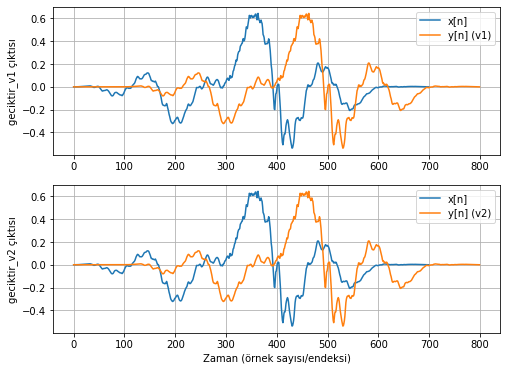

In [ ]:
# Sinyalin dosyadan okunması
ses, ornekleme_fr = sf.read('speech-male.wav')

# Uzun ses sinyalinden elle seçilmiş bir kısmının alınması ve pencere fonksiyonu ile çarpılması
baslangic_endeksi = 8800; bitis_endeksi = 9500; # başlangıç ve bitiş noktası değerleri keyfi seçildi
x_n = ses[baslangic_endeksi:bitis_endeksi] * signal.get_window('hann', bitis_endeksi-baslangic_endeksi)

# Sinyali girdi olarak kullanarak geciktir_v1 ve geciktir_v2 fonksiyonlarının 
#  çıktılarını elde edip girdi sinyali ile beraber görselleştirelim
n0 = 100 # örnek sayısı cinsinden gecikme miktarı

fig = plt.figure(figsize=(8,6))

plt.subplot(2,1,1)
plt.plot(x_n, label='x[n]')
plt.plot(geciktir_v1(x_n, n0), label='y[n] (v1)') # geciktir_v1 çıktısı çizdiriliyor
plt.ylabel("geciktir_v1 çıktısı")
plt.legend();plt.grid();

plt.subplot(2,1,2)
plt.plot(x_n, label='x[n]')
plt.plot(geciktir_v2(x_n, n0), label='y[n] (v2)') # geciktir_v2 çıktısı çizdiriliyor
plt.ylabel("geciktir_v2 çıktısı")
plt.xlabel("Zaman (örnek sayısı/endeksi)")
plt.legend();plt.grid();

Şekil 2.2: *Geciktirme sistemi girdi($x[n]$) ve çıktı($y[n]$) sinyalleri*

İki fonksiyon ile de aynı çıktıyı aldık. `geciktir_v1` ve `geciktir_v2` fonksiyonları aynı sonucu üretiyor.



Sistemin dürtü cevabını biliyoruz: 


$$h[n] = \delta[n-n_0]$$


Sistemin bir de frekans cevabını çizdirelim. Bunun için dürtü cevabının ($h[n]$) Fourier dönüşümünü [numpy.fft.fft](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html) fonksiyonu ile elde edip çizdirelim. 

In [ ]:
# Numpy.fft.fft fonksiyonu kullanarak frekans cevabı çizdiren fonksiyon
def frekans_cevabi_cizdir(x_n, frekans_nokta_sayisi=512):
  # Fourier dönüşümü bize simetrik bir sonuç vereceği için bütününü oluşturduktan sonra ilk kısmını alalım
  # bu amaçla iki kat boyut kullanıp ortadan böleceğiz
  X_f = np.fft.fft(x_n, frekans_nokta_sayisi * 2)
  X_f = X_f[:frekans_nokta_sayisi]
  
  # Genlik ve faz bileşenlerinin hesaplanması
  genlik_w = np.abs(X_f)
  faz_w = np.angle(X_f)

  # Spektrum çizdirme adımları
  plt.figure(figsize=(12,3))

  plt.subplot(1,2,1)
  plt.title('Genlik spektrumu')
  plt.plot(genlik_w, 'b')
  plt.ylabel('|X(f)|', color='b')
  plt.xlabel('frekans [örnek endeksi]')
  plt.grid()
  
  plt.subplot(1,2,2)
  plt.title('Faz spektrumu (katlanmış)')
  plt.plot(faz_w, 'b')
  plt.ylabel('faz(X(f)) (radyan)', color='b')
  plt.xlabel('frekans [örnek endeksi]')
  plt.grid()
  plt.show()

$h[n] = \delta[n-n_0]$ sinyalini 200 örnek içerecek şekilde oluşturup karşılık gelen frekans cevabını çizdirelim

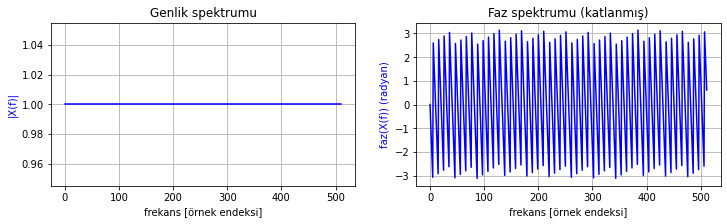

In [ ]:
n0 = 100 # örnek sayısı cinsinden gecikme miktarı
N = n0 * 2 # dürtü cevabı uzunluğu, deltayı içerecek şekilde yeterince uzun seçelim
h_n = np.zeros((N,))
h_n[n0] = 1
frekans_cevabi_cizdir(h_n)

Şekil 2.3: *Geciktirme sistemi frekans cevabı*

Çizdirilen frekans cevabını incelediğimizde gecikme sisteminin sinyalin her frekanstaki bileşenini 1 ile çarptığını (genliğini değiştirmediğini), sadece fazı değiştirdiğini görebiliyoruz. Faz oldukça karışık bir görünüme sahip. Bunun temel nedeni fazın $[-\pi, \pi]$ aralığında temsil edilmesi (diğer bir deyişle faz spektrumunun bu aralığa "katlanması" (warping)). Spektrumdaki gerçek bir faz değerinin $6.5\pi$ olduğunu düşünün. Eldeki kompleks sayıdan fazı elde ederseniz sonucu $0.5\pi$ olarak gözleyeceksiniz. İşte bu tüm spektruma uygulanmış, bu sebeple faz spektrumu $[-\pi, \pi]$ aralığına katlanmış olarak gösterilmektedir. Katlanmış spektrumu açmak çoğu zaman zor bir işlemdir ancak basit sinyaller için [numpy.unwrap](https://numpy.org/doc/stable/reference/generated/numpy.unwrap.html) fonksiyonunu kullanmayı deneyebiliriz. Aşağıda frekans spektrum çizdirme fonksiyonumuzu bu adımı ekleyerek tekrar yazalım ve kullanalım:

In [ ]:
# Numpy.fft.fft fonksiyonu kullanarak frekans cevabı çizdiren fonksiyon (faz spektrumunu numpy.unwrap ile açar)
def frekans_cevabi_cizdir(x_n, frekans_nokta_sayisi=512):
  # Fourier dönüşümü bize simetrik bir sonuç vereceği için bütününü oluşturduktan sonra ilk kısmını alalım
  # bu amaçla iki kat boyut kullanıp ortadan böleceğiz
  X_f = np.fft.fft(x_n, frekans_nokta_sayisi * 2)
  X_f = X_f[:frekans_nokta_sayisi]

  # Genlik ve faz bileşenlerinin hesaplanması
  genlik_w = np.abs(X_f)
  faz_w = np.unwrap(np.angle(X_f)) # "unwrap"(katlamayı açma) işlemi eklendi
  
  # Spektrum çizdirme adımları
  plt.figure(figsize=(12,3))
  
  plt.subplot(1,2,1)
  plt.title('Genlik spektrumu')
  plt.plot(genlik_w, 'b')
  plt.ylabel('|X(f)|', color='b')
  plt.xlabel('frekans [örnek endeksi]')
  plt.grid()
  
  plt.subplot(1,2,2)
  plt.title('Faz spektrumu')
  plt.plot(faz_w, 'b')
  plt.ylabel('faz(X(f)) (radyan)', color='b')
  plt.xlabel('frekans [örnek endeksi]')
  plt.grid()
  plt.show()

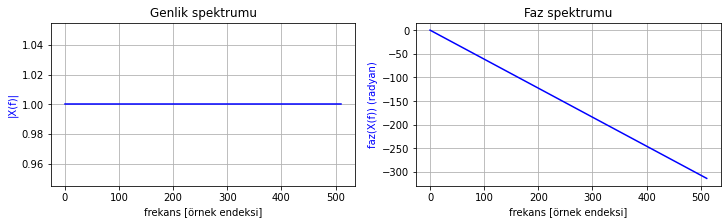

In [ ]:
frekans_cevabi_cizdir(h_n)

Şekil 2.4: *Geciktirme sistemi frekans cevabı (faz spektrumu katlaması açılmış (phase unwrapped))*

Faz spektrumumuz doğrusallaştı. Faz spektrumunun doğrusal olması oldukça önemli bir özellik. Doğrusal fazlı bir sistem, girdi sinyalinin içerisindeki farklı frekansta bileşenlerin hepsinin zamanda aynı miktarda kaydıracaktır. Bu özelliği defterimizin sonuna doğru örnek üzerinden açıklıyoruz. Şimdi bir sonraki sistemimizi ele alalım. 

### Hareketli ortalama filtresi (Moving average filter)

Şimdi bir sinyalin küçük varyasyonlarını gözardı edip genel yönelimini izlememize yardımcı olan bir sistemi ele alalım. Finansal veriler üzerinde sıkça uygulanan bu filtre/sistem, verinin belirli aralıklarda ortalamalarını hesaplamaya dayanır. Örneğin elimizde saatlik Dolar/TL parite değerlerini içeren bir sinyal olduğunu düşünelim. Saatlik veriler çok fazla iniş-çıkış içereceği için günlük ortalama, haftalık ortalama, aylık ortalama alarak değişimleri gözlemek isteyebiliriz. Bu sistem girdi olarak aldığı sinyali belirlediğimiz genişlikte pencerelere bölüp, ortalama hesaplayıp, elde ettiği değerleri içeren yeni bir sinyali çıktı olarak verecektir. Sistemi şu formülle tanımlayabiliriz:


$$y[n] = \frac{1}{M_1+M_2+1} \sum_{k = -M_1}^{M_2} x[n-k]$$


Burada, çıktının $n$. noktadaki değerini ($y[n]$) hesaplarken girdinin $n$. noktadan $M_1$ örnek öncesi ile $M_2$ örnek sonrası arası değerlerinin ortalaması alınmaktadır.   Şimdi ilk olarak sistemi gerçeklemek için, bu denklemdeki toplama işlemini gerçekleştiren bir fonksiyon yazalım: 

In [ ]:
# Tanımdan yola çıkarak sistem gerçekleme
def hareketli_ortalama_v1(x_n, M_1, M_2):
  y_n = np.zeros_like(x_n)
  # Sinyalin her bir noktasının çevresinde bir kesit alınıp ortalamasının hesaplanması
  for ind in range(M_1, x_n.size - M_2):
    y_n[ind] = np.sum(x_n[ind-M_1:ind+M_2+1]) / (M_1 + M_2 + 1)
  return y_n 

Dürtü cevabını oluşturarak da sistemimizi gerçekleyebiliyorduk, bunu da yapalım. 


$$h[n] = \frac{1}{M_1+M_2+1} \sum_{k = -M_1}^{M_2} \delta[n-k]$$


$h[n]$, $n=-M_1$ ve $n=+M_2$ arasında $\delta$ sinyallerinin toplamında oluşuyor. Öncelikle $h[n]$i oluşturalım, çizdirelim ve inceleyelim:

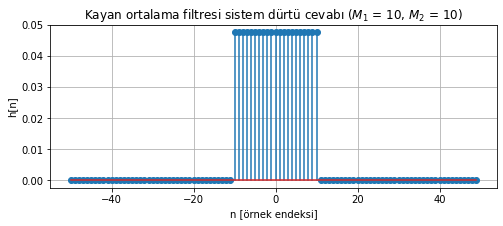

In [ ]:
N = 100 # sinyaldeki toplam örnek sayısı 
M_1 = 10; M_2 = 10; # rasgele seçilmiş M1 ve M2 değerleri
n = np.arange(- N // 2, N // 2)
h_n = np.zeros((N,))
h_n[ np.logical_and(-M_1 <= n , n <= M_2)] = 1
h_n = h_n / (M_1 + M_2 + 1)
fig = plt.figure(figsize=(8,3))
plt.title('Hareketli ortalama filtresi dürtü cevabı ($M_1$ = 10, $M_2$ = 10)')
plt.ylabel('h[n]');plt.xlabel('n [örnek endeksi]');
plt.stem(n, h_n);plt.grid();

Şekil 2.5: *Hareketli ortalama sistemi dürtü cevabı*

Şimdi sistemimizi dürtü cevabı oluşturup girdi sinyaliyle konvolüsyon gerçekleştirecek şekilde yazalım:

In [ ]:
# Dürtü cevabı kullanarak sistem gerçekleme
def hareketli_ortalama_v2(x_n, M_1, M_2):
  # Dürtü cevabının oluşturulması
  N = M_1 + M_2 + 1 # sinyaldeki toplam örnek sayısı 
  h_n = np.ones((N,))
  h_n = h_n / N

  # Çıktıyı konvolüsyon ile hesaplama
  y_n = np.convolve(x_n, h_n)
  
  # Konvolüsyon sonucu sinyal uzadı, keserek x_n ile aynı uzunlukta döndürelim
  return y_n[M_1:M_1+x_n.size]

Şimdi yazdığımız iki fonksiyonla elde ettiğimiz çıktıları karşılaştıralım:

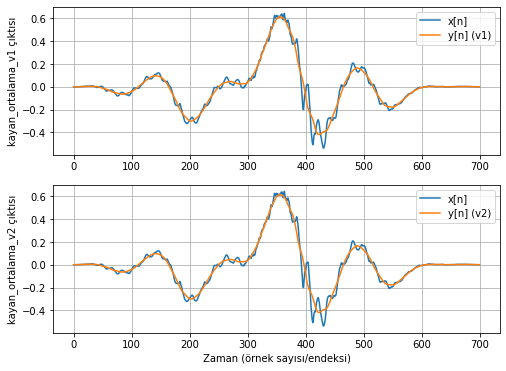

In [ ]:
# Sinyali girdi olarak kullanarak hareketli_ortalama_v1 ve hareketli_ortalama_v2 
#. fonksiyonlarının çıktılarını elde edip girdi sinyali ile beraber görselleştirelim
M_1 = 10; M_2 = 10;

fig = plt.figure(figsize=(8,6))

plt.subplot(2,1,1)
plt.plot(x_n, label='x[n]')
plt.plot(hareketli_ortalama_v1(x_n, M_1, M_2), label='y[n] (v1)') # hareketli_ortalama_v1 çıktısı çizdiriliyor
plt.ylabel("hareketli_ortalama_v1 çıktısı")
plt.legend();plt.grid();

plt.subplot(2,1,2)
plt.plot(x_n, label='x[n]')
plt.plot(hareketli_ortalama_v2(x_n, M_1, M_2), label='y[n] (v2)') # hareketli_ortalama_v2 çıktısı çizdiriliyor
plt.ylabel("hareketli_ortalama_v2 çıktısı")
plt.xlabel("Zaman (örnek sayısı/endeksi)")
plt.legend();plt.grid();

Şekil 2.6: *Hareketli ortalama sistemi girdi($x[n]$) ve çıktı($y[n]$) sinyalleri*

İki fonksiyonla aynı sonucu elde ettiğimizi doğrulamış olduk. Şimdi sistemin frekans cevabını inceleyelim:

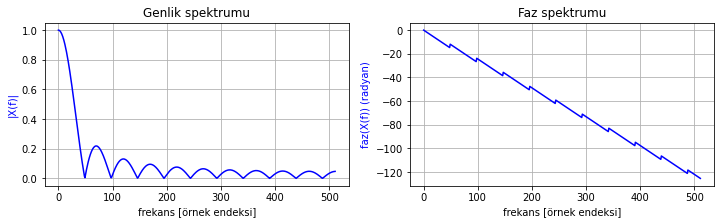

In [ ]:
frekans_cevabi_cizdir(h_n)

Şekil 2.7: *Hareketli ortalama sistemi frekans cevabı*

Sistemimizin düşük geçiren bir filtre olduğunu görebiliyoruz. Bir sonraki sistem örneğimize geçelim.

### Kümülatif toplam yapan sistem (Accumulator function)

Basit sistemlerden bir diğeri çıktı sinyalinin $n$ anındaki değerini hesaplamak için girdi sinyalinin $n$ ve $n$'den küçük (geçmiş) değerlerinin tümünü toplayan sistemdir. Bu bir çeşit integral olarak da düşünülebilir. 


$$y[n] = \sum_{k = -\infty}^{n} x[k]$$

Sistemin dürtü cevabını bulmak için her zaman olduğu gibi girdi sinyali yerine delta fonksiyonunu yazabiliriz:

$$x[n] = \delta[n]$$

Sonuçta elde edilen dürtü cevabı:

$$h[n] = u[n]$$

olarak hesaplanabilir. 

Sistemimizin dürtü cevabı birim basamakmış. Birim basamak sinyalini ilk defterimizin başında oluşturmuştuk. Aynı örneği tekrar inceleyelim:

$$u[n] =
  \begin{cases}
    0,  & \quad n < 0\\
    1,  & \quad n \geq 0
  \end{cases}
$$

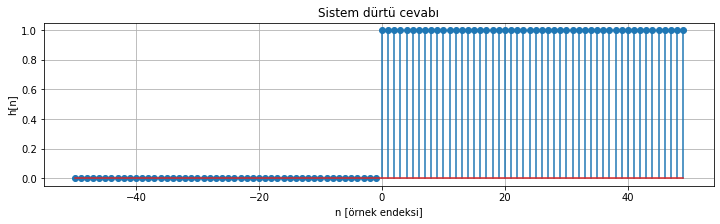

In [ ]:
N = 100 # seçilen örnek sayısı
n = np.arange(- N // 2, N // 2)
h_n_integral = np.zeros((N, )) 
h_n_integral[n >= 0] = 1

# Oluşturduğumuz dürtü cevabını çizdirelim
fig = plt.figure(figsize=(12,3))
plt.title('Sistem dürtü cevabı')
plt.ylabel('h[n]');plt.xlabel('n [örnek endeksi]');
plt.stem(n, h_n_integral);plt.grid();

Şekil 2.8: *Akümülatör sistemi dürtü cevabı*

Frekans cevabını da çizdirelim:

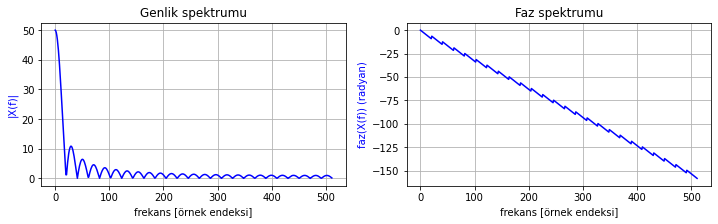

In [ ]:
frekans_cevabi_cizdir(h_n_integral)

Şekil 2.9: *Akümülatör sistemi frekans cevabı*

Yine düşük geçiren bir sistem elde ettik. **Burada önemli bir nokta sistemin sonsuz uzunlukta bir dürtü cevabı (IIR: Infinite impulse response) olması ancak bizim $h[n]$ vektörünü sınırlı uzunlukta tutmak zorunda olmamızdır. Zamanda sınırlandırma yaptığımız durumda sistemin karakterini ve spektrumunu da değiştiririz. IIR sistemleri bu sebeple dürtü cevabı oluşturarak gerçeklememeyi tercih ederiz. Alternatif gerçekleme yöntemini ileride ele alacağız.** Bu sistem özelinde: bu sistem stabil bir sistem olmadığı (dürtü cevabı toplamı sonlu olmadığı) için zaten sistemin frekans cevabını (Fourier dönüşümünü) hesaplayıp çizdiremeyiz ([bakınız](https://ccrma.stanford.edu/~jos/st/Existence_Fourier_Transform.html))). Yalnızca dürtü cevabını sınırlandırdığımız durumda dönüşüm hesaplayıp bir çizim elde edebiliyoruz.

### Fark/türev sistemi (Differentiator)

Yukarıda integral alan sistem tanımlamıştık. Şimdi ters işlem olan fark alan sistemi tanımlayalım:

$$y[n] = x[n] - x[n-1]$$

Bu sistem $n$ anındaki çıktıyı, girdi sinyalinin o andaki değerinin bir önceki değerinden farkı olarak hesaplar.
Dürtü cevabını hesaplamak için $x[n] = \delta[n]$ yazarsak:

$$h[n] = \delta[n] - \delta[n-1]$$

Dürtü cevabını oluşturalım ve spektrumuyla beraber çizdirelim:

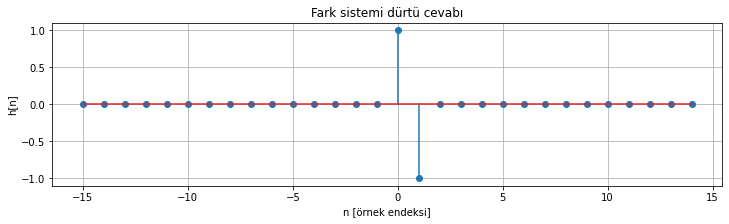

In [ ]:
N = 30
n = np.arange(- N // 2, N // 2)
h_n_fark = np.zeros((N, )); 
h_n_fark[n==0] = 1; h_n_fark[n==1] = -1 
fig = plt.figure(figsize=(12,3))
plt.stem(n, h_n_fark);plt.grid();plt.title('Fark sistemi dürtü cevabı');
plt.ylabel('h[n]');plt.xlabel('n [örnek endeksi]');

Şekil 2.10: *Fark sistemi dürtü cevabı*

Bu sistemin dürtü cevabı sınırlı uzunluğa sahip (FIR: finite impulse response). Sıfırları dışarıda bırakarak temsil etmemizde bir sakınca yok. 

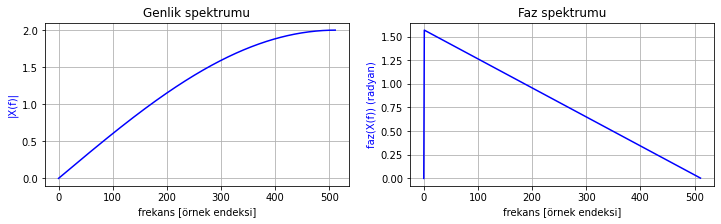

In [ ]:
h_n_fark = np.array([1,-1])
frekans_cevabi_cizdir(h_n_fark)

Şekil 2.11: *Fark sistemi frekans cevabı*

Fark sisteminin yüksek geçiren bir filtre karakteristiği olduğunu gözlemlemiş olduk. İntegral alan sistem ile tam ters karakteristiğe sahip olmasını beklerken gözlemimiz bunu doğrulamadı. Bunun sebebi IIR olan integral sistemini sınırlı uzunluktaki bir dürtü cevabı ile temsil etmemiz oldu. 

Verilen iki sistemin birbirinin tersi olup olmadığını seri bağlandıklarında birbirlerinin etkisini yok edip etmediklerini test ederek inceleyebiliriz. Ardışık bağlanan bu iki sistemi tek bir sistem olarak ele alıp, bu birleşik sistemin aldığı girdi sinyalini bozmadan çıktıda verip vermediği kontrol edilebilir. (*figürde sorunlar var*)

| <img src="http://signalsandsystems.wdfiles.com/local--files/notes-timedomain-property-invertibility/ch2.7.5.jpg" width=400 height=150 /> |
| :--------------------------------------------------------------------------------------------------------------------------------------: |
|                                  Şekil 2.12: _Ters sistemlerin seri bağlanması ile elde edilen sistem_                                   |

Şunu kontrol etmek istiyoruz:

$y[n] = h^{-1}[n]\circledast(h[n] \circledast x[n]) = (h^{-1}[n]\circledast h[n]) \circledast x[n] =? x[n]$

Bu doğruluğun sağlanabilmesi için;

$h^{-1}[n] \circledast h[n] = \delta[n]$ olmalı. Bunu elimizdeki akümülatör ve fark sistemleri için kontrol edelim;

$h^{-1}[n] \circledast h[n] = u[n] \circledast (\delta[n] - \delta[n-1])$
$ = u[n] \circledast \delta[n] - u[n] \circledast \delta[n-1]$

$ = u[n] - u[n-1]$

$ = \delta[n]$

Evet, bu iki sistemin birbirinin tersi olduğunu doğruladık. Sinyal örneği üzerinden de bir test yapabiliriz. İntegral sistemini sadece pozitif zamandaki değerlerinden ibaret oluşturursak elimizdeki sinyal üzerinde bunu aşağıdaki gibi doğrulamayı deneyebiliriz. 

$x[n]$ → integal → fark → ? $x[n]$

Girdi ve çıktı sinyallerini beraber çizdirelim ve ne düzeyde örtüştüklerini görsel olarak incelemeye çalışalım. Çizimde üstüste bineceği için sinyallerden birisini y ekseninde 0.1 birim kaydırarak çizdireceğiz. (siz bu bileşeni dışarıda bırakıp deneyi tekrarlayabilirsiniz)

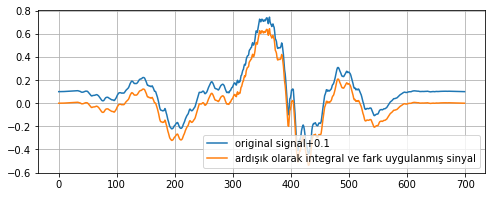

In [ ]:
h_n_integral = np.ones_like(x_n)
h_n_fark = np.array([1,-1])
# x[n] -> integral 
ilk_sistem_y_n = np.convolve(x_n, h_n_integral)
# -> fark -> ...
ikinci_sistem_cikti = np.convolve(ilk_sistem_y_n, h_n_fark)

fig = plt.figure(figsize=(8,3))
plt.plot(x_n+0.1, label='original signal+0.1') # üstüste çakışmayı önleme için sinyale 0.1 eklendi
plt.plot(ikinci_sistem_cikti[:x_n.size], label='ardışık olarak integral ve fark uygulanmış sinyal')
plt.legend();plt.grid();

Şekil 2.13: *Birbirinin tersi olan sistemlerin seri bağlanması sonucu elde edilen sistemin girdi ve çıktı sinyalleri. (girdi sinyali y ekseninde 0.1 kaydırılmıştır)*

Evet, sistemler seri bağlanarak oluşturulan sistemin girdi ile aynı çıktıyı ürettiğini bu örnekte görmüş olduk.

İki sistemin dürtü cevaplarının konvolüsyonunu hesaplayıp delta fonksiyon elde edip etmediğimizi de kontrol edebilirdik:

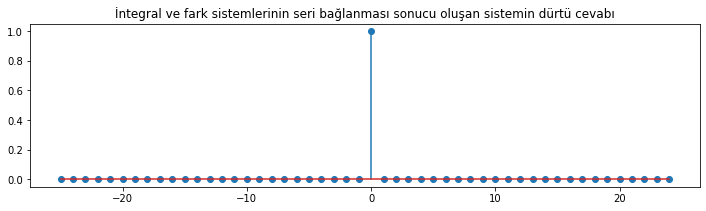

In [ ]:
N = 50
n = np.arange(- N // 2, N // 2)

h_n_integral = np.zeros((N, )); h_n_integral[n >= 0] = 1
h_n_fark = np.zeros((N, )); h_n_fark[0] = 1;h_n_fark[1] = -1

sonuc = np.convolve(h_n_integral, h_n_fark)
sonuc = sonuc[:N]

fig = plt.figure(figsize=(12,3))
plt.stem(n, sonuc);plt.title('İntegral ve fark sistemlerinin seri bağlanması sonucu oluşan sistemin dürtü cevabı');

Şekil 2.14: *Bir sistemin dürtü cevabının ters sistemin dürtü cevabı ile konvolüsyonu sonucu elde edilen bileşik sistem dürtü cevabı*

Bu testte de iki sistemin birbirinin tersi olduğu beklentimiz (sonuç $\delta[n]$ çıktığı için) doğrulandı.

## Egzersizler/Örnekler

### Egzersiz/örnek 1

Girdi sinyalini 10 ile çarparak yükselten bir sistemin frekans cevabını çizdiren bir kod parçası yazınız.


$$y[n] = 10x[n]$$

$$h[n] = 10\delta[n]$$

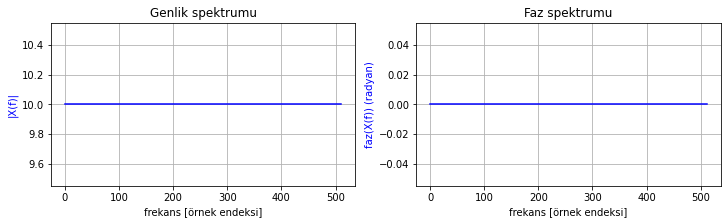

In [ ]:
carpan = 10
imp_resp_duration_n = 10
delta_n = np.zeros((imp_resp_duration_n,))
delta_n[0] = 1
h_n = carpan * delta_n
frekans_cevabi_cizdir(h_n)

Şekil 2.15: *Sabit kazanç uygulayan sistem frekans cevabı*

Sistem tüm frekanslardaki bileşenlerin genliklerini 10 ile çarpıyor ve fazlarını değiştirmiyor. 

### Egzersiz/örnek 2

Nedensel bir sistemin dürtü cevabı aşağıdaki gibi verilmiştir: 

$h[n]$ = [0.02455383, 0.23438946, 0.4821134,  0.23438946, 0.02455383]

Sistemin frekans cevabını çizdiriniz. Sistem düşük geçiren mi yüksek geçiren midir? 

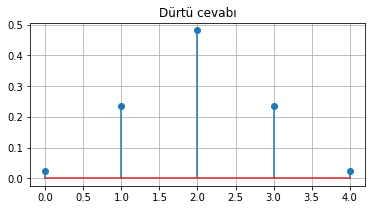

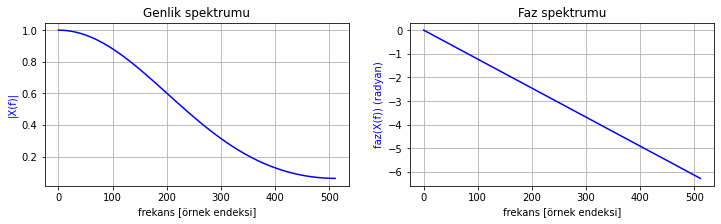

In [ ]:
h_n = np.array([0.02455383, 0.23438946, 0.4821134, 0.23438946, 0.02455383])
fig = plt.figure(figsize=(6,3))
plt.stem(h_n);plt.grid();plt.title('Dürtü cevabı')
frekans_cevabi_cizdir(h_n)

Şekil 2.16: *Egzersiz 2'de dürtü cevabı verilen sistemin frekans cevabı*

Sistem düşük geçiren bir filtre karakteristiği göstermektedir.  Bu örneği hazırlamak için dürtü cevabını hazır bir filtre tasarım fonksiyonu kullanarak oluşturduk. Altta kullandığımız kodu bulabilirsiniz:

In [ ]:
uzunluk = 5 # h[n]'in uzunluğu
f_kesim = 0.25 # kesim frekansı frekans bandının ilk çeyreğinde seçilmiş
h_n = signal.firwin(uzunluk, f_kesim)
print(h_n)

[0.02455383 0.23438946 0.4821134  0.23438946 0.02455383]


Yukarıdaki örnekteki filtrenin hazır bir FIR filtre tasarım fonksiyonu kullanılarak oluşurulduğunu görmüş olduk. Siz de ihtiyaç duyduğunuzda [signal.firwin](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin.html) fonksiyonu ile arzu ettiğiniz kesim frekansına sahip filtre tasarlayıp filtrenin dürtü cevabını elde edebilirsiniz. Burada önemli detaylardan birisi de oluştural filtrenin faz spektrumunun doğrusal olması; uygulandığı sinyalin değişik frekanslardaki bileşenlerini zamanda eşit miktarda kaydırmasıdır. Tasarlanan sistemin dürtü cevabının zamanda simetrik olması bu özelliği garanti altına alır. 

### Egzersiz/örnek 3

Örnek olarak sırasıyla bir düşük geçiren, bir yüksek geçiren, bir de bant geçiren filtre tasarlayıp elimizdeki örnek ses sinyaline uygulayıp sonucu dinleyip sistemlerin etkilerini deneyimleyelim.

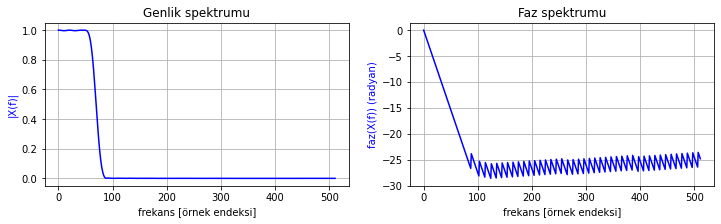

In [ ]:
# Konuşma sinyaline 3000 Hz kesim frekanslı düşük geçiren filtre uygulanması
uzunluk = 101 # h[n]'in uzunluğu
f_max = ornekleme_fr //2 # Örnekleme kuramına göre sinyalde temsil edilen maksimum frekans
f_kesim = 3000 # kesim frekansını 3000 Hz olarak belirleyelim
f_norm = f_kesim / f_max # scipy.signal.firwin "cutoff" parametresi, maksimum frekansa oran olarak 0-1 aralığında belirleniyor
LP_h_n = signal.firwin(uzunluk, f_norm, pass_zero = "lowpass")
frekans_cevabi_cizdir(LP_h_n)
filtrelenmis_ses = np.convolve(ses, LP_h_n)
IPython.display.Audio(filtrelenmis_ses, rate=ornekleme_fr)

Şekil 2.17: *Düşük geçiren filtre frekans cevabı*

Yukarıdaki üçgen "play" butonuna tıklayarak filtre çıktısı elde edilen sesi dinleyebilirsiniz.

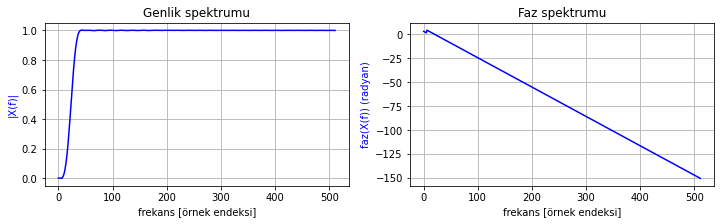

In [ ]:
# Konuşma sinyaline 1000 Hz kesim frekanslı yüksek geçiren filtre uygulanması
uzunluk = 101
f_max = ornekleme_fr //2 # Örnekleme kuramına göre sinyalde temsil edilen maksimum frekans
f_kesim = 1000 # kesim frekansını 1000 Hz olarak belirleyelim
f_norm = f_kesim / f_max
LP_h_n = signal.firwin(uzunluk, f_norm, pass_zero = "highpass")
frekans_cevabi_cizdir(LP_h_n)
filtrelenmis_ses = np.convolve(ses, LP_h_n)
IPython.display.Audio(filtrelenmis_ses, rate=ornekleme_fr)

Şekil 2.18: *Yüksek geçiren filtre frekans cevabı*

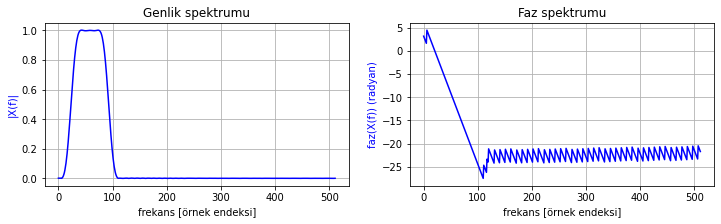

In [ ]:
# Konuşma sinyaline 1000 Hz - 4000 Hz kesim frekanslı bant geçiren filtre uygulanması
uzunluk = 101
f_max = ornekleme_fr //2 # Örnekleme kuramına göre sinyalde temsil edilen maksimum frekans
f_kesim = np.array([1000, 4000]) # kesim frekanslarını [1000, 4000] Hz olarak belirleyelim
f_norm = f_kesim / f_max
LP_h_n = signal.firwin(uzunluk, f_norm, pass_zero = "bandpass")
frekans_cevabi_cizdir(LP_h_n)
filtrelenmis_ses = np.convolve(ses, LP_h_n)
IPython.display.Audio(filtrelenmis_ses, rate=ornekleme_fr)

Şekil 2.19: *Bant geçiren filtre frekans cevabı*

### Egzersiz/örnek 4

**İdeal filtre dürtü cevabından yola çıkarak filtre tasarımı:** scipy.signal.firwin fonksiyonunu kullanmak yerine FIR filtre tasarımını, [ideal filtre cevabı](https://ccrma.stanford.edu/~jos/sasp/Ideal_Lowpass_Filter.html)ndan yola çıkarak kendimiz de oluşurabilirdik. 

$$h[n] = \frac{sin(nw_c)}{n\pi}$$

Şimdi bu ifadede tanımlı dürütü cevabını $w_c = 0.5\pi$ için farklı uzunluklarda oluşturup frekans cevaplarını inceleyelim.

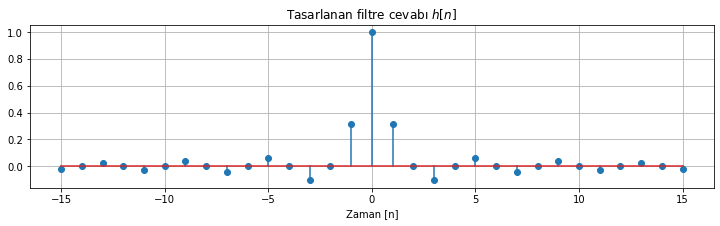

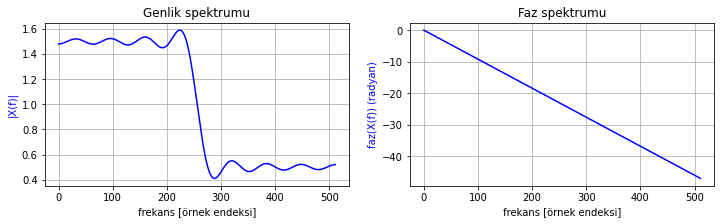

In [ ]:
N = 31
w_c = 0.5 * np.pi
n = np.arange(-N//2 + 1, N//2 + 1)
h_n = np.sin(w_c * n) / (np.pi * n)
h_n[n==0] = 1 # n= 0'da nan olarak hesaplanır, 1 olmalı
fig = plt.figure(figsize=(12.25,3))
plt.stem(n, h_n);plt.grid();plt.title('Tasarlanan filtre cevabı $h[n]$')
plt.xlabel('Zaman [n]')
frekans_cevabi_cizdir(h_n)

Şekil 2.20: *31 nokta uzunluğunda kesilmiş bir ideal filtre dürtü cevabının frekans cevabı*

Şekil 2.20'den bir düşük geçiren filtre tasarlanmış olduğunu doğrulayabiliyoruz. Ancak frekans cevabı ideal filtre cevabından biraz sapmış (kesim frekansında iniş ani değil ve bazı ek osilasyonlar(ripples) mevcut). Bu sapma dürtü cevabını 31 nokta içerecek şekilde oluşturmamızdan kaynaklandı. Daha fazla örnek kullanalım:

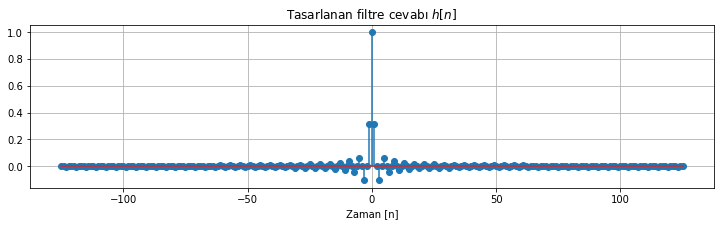

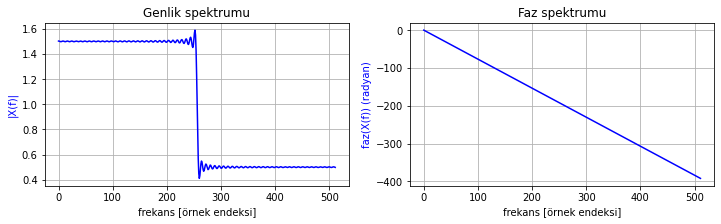

In [ ]:
N = 251
w_c = 0.5 * np.pi
n = np.arange(-N//2 + 1, N//2 + 1)
h_n = np.sin(w_c * n) / (np.pi * n)
h_n[n==0] = 1 # n= 0'da nan olarak hesaplanır, 1 olmalı
fig = plt.figure(figsize=(12.25,3))
plt.stem(n, h_n);plt.grid();plt.title('Tasarlanan filtre cevabı $h[n]$')
plt.xlabel('Zaman [n]')
frekans_cevabi_cizdir(h_n)

Şekil 2.21: *251 nokta uzunluğunda kesilmiş bir ideal filtre dürtü cevabının frekans cevabı*

Şekilde 2.20 ve 2.21 karşılaştırıldığında şu sonuca varabiliriz: filtremizin uzunluğu/derecesi/karmaşıklığı arttıkça karakteristiği ideale yaklaşıyor. 

### Egzersiz/örnek 5

**Filtreleri seri bağlayarak filtre tasarlama:** Bant geçiren bir filtreyi bir düşük geçiren filtre ile bir yüksek geçiren filtreyi arka arkaya bağlayarak da oluşturabiliriz. Bir örnek görelim:

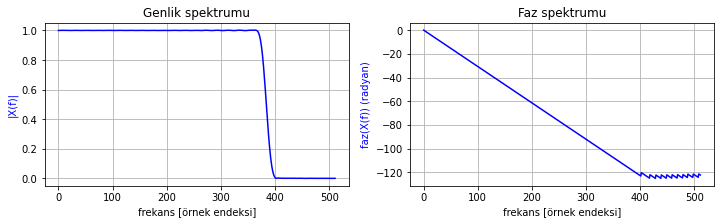

In [ ]:
# Düşük geçiren filtre tasarımı
uzunluk = 101
f = 0.75
LP_h_n = signal.firwin(uzunluk, f)
frekans_cevabi_cizdir(LP_h_n)

Şekil 2.22: *Düşük geçiren filtre frekans cevabı*

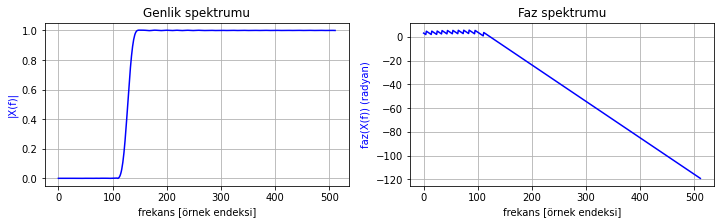

In [ ]:
# Yüksek geçiren filtre tasarımı
uzunluk = 101
f = 0.25
HP_h_n = signal.firwin(uzunluk, f, pass_zero=False)
frekans_cevabi_cizdir(HP_h_n)

Şekil 2.23: *Yüksek geçiren filtre frekans cevabı*

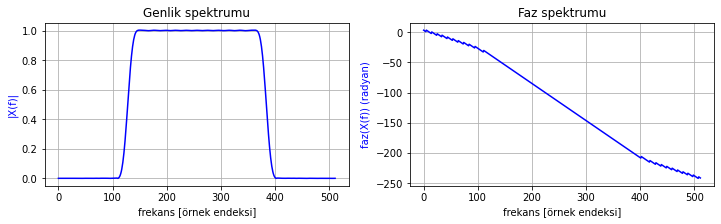

In [ ]:
# Bant geçiren filtrenin yukarıdaki iki filtrenin seri bağlanması ile oluşturulması
BP_h_n = np.convolve(LP_h_n, HP_h_n)
frekans_cevabi_cizdir(BP_h_n)

Şekil 2.24: *Yüksek geçiren ve düşük geçiren filtrelerin seri bağlanması ile elede edilen bant geçiren filtrenin frekans cevabı*

## Sistem frekans cevabının fazının doğrusallığı neden önemli?

Yukarıdaki filtrelerin geçirme bandında faz spektrumlarının doğrusal olduğunu gözleyebiliyoruz. Bu bir rastlantı değil, özellikle fazları doğrusal olacak şekilde tasarlanıyorlar. Bu FIR filtre tasarımında, filtrenin dürtü cevabı ($h[n]$) simetrik yapılarak sağlanıyor (bu özelliğin ispatı için [bu dokümana bakınız](https://hal.archives-ouvertes.fr/hal-01849361/document)). Şimdi fazı doğrusal olan ve fazı doğrusal olmayan iki sistem düşünelim ve çıktı sinyaline bu durumun nasıl bir etkisi olduğunu gözleyelim. Bu etkiye odaklanabilmek için genlik spektrumunun her frekansta 1 olduğunu varsayalım ve sinyal bileşenlerine sadece fazın etkisini ekleyelim.  

Sistem-1 faz spektrumu doğrusal: $\angle{H_{s1}(e^{jw})} = 0.02w$

Sistem-2 faz spektrumu doğrusal olmayan: $\angle{H_{s2}(e^{jw})} = w^2$
olsun.

Girdi sinyali bu sistemlerden geçtiğinde oluşan çıktı sinyalinin spektrumunu şu şekilde hesaplayabiliriz:

$Y(e^{jw}) = H(e^{jw})X(e^{jw})$

Buradaki çarpma işlemi kompleks sayıların çarpımı şeklinde olduğu için genlik spektrumu sistemin genlik spektrumu ile çarpılacak, 
$|Y(e^{jw})| = |H(e^{jw})||X(e^{jw})|$

faz spektrumu ise sistem faz spektrumu ile toplanacak. 

$\angle{Y(e^{jw})} = \angle{H(e^{jw})} + \angle{X(e^{jw})}$


Faz spektrumu farklı (biri doğrusal, diğeri doğrusal olmayan) bu iki sistemin, girdi sinyaline etkisini incelemek için, 3 harmonik içeren bir girdi sinyali oluşturalım. Girdi sinyalini ve oluşacak çıktı sinyallerini çizdirelim.

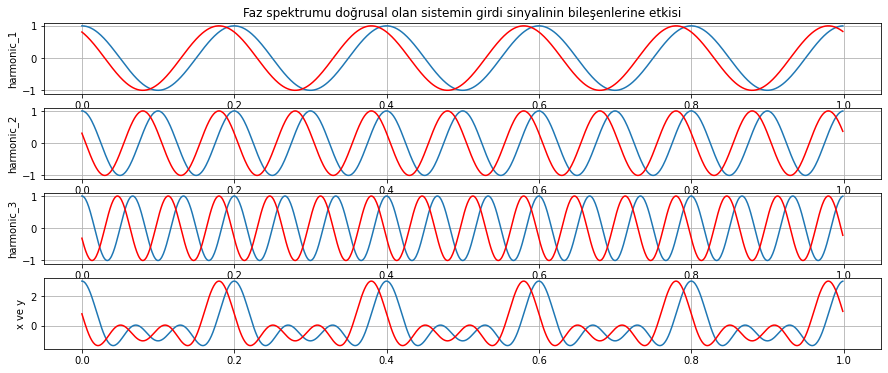

In [ ]:
# Faz sepktrumu doğrusal olan sistem 1'in girdi sinyalinin bileşenlerine etkisi
f_sample = 1000
f0 = 5
t = np.arange(0,1,1/f_sample)

fig = plt.figure(figsize=(15,6))

plt.subplot(4,1,1)
plt.title('Faz spektrumu doğrusal olan sistemin girdi sinyalinin bileşenlerine etkisi')

x = np.zeros_like(t)
y = np.zeros_like(t)
for k in range(1,4):
  w = 2*np.pi*f0*k
  harmonic_k_x = np.cos(w*t)
  harmonic_k_y = np.cos(w*t + 0.02*w) # sistemin faz etkisi eklendi
  plt.subplot(4,1,k)
  x += harmonic_k_x
  y += harmonic_k_y
  plt.plot(t, harmonic_k_x);plt.ylabel('armonik_'+str(k));
  plt.plot(t, harmonic_k_y, 'r');plt.ylabel('armonik_'+str(k));plt.grid();  

plt.subplot(4,1,4)
plt.plot(t, x);plt.plot(t, y, 'r');plt.ylabel('x ve y');plt.grid();

Şekil 2.25: *Doğrusal fazlı bir sistemin girdi sinyalinin bileşenlerine etkisi. Girdi sinyali ve bileşenleri mavi, çıktı sinyali ve bileşenleri kırmızı olarak gösterilmektedir.*

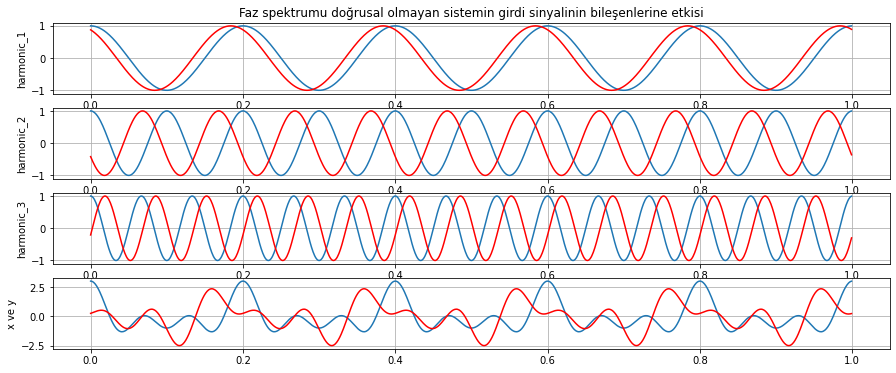

In [ ]:
# Faz spektrumu doğrusal olmayan sistem 2'in girdi sinyalinin bileşenlerine etkisi
f_sample = 1000
f0 = 5
t = np.arange(0,1,1/f_sample)
fig = plt.figure(figsize=(15,6))
plt.subplot(4,1,1)
plt.title('Faz spektrumu doğrusal olmayan sistemin girdi sinyalinin bileşenlerine etkisi')
x = np.zeros_like(t)
y = np.zeros_like(t)
for k in range(1,4):
  w = 2*np.pi*f0*k
  harmonic_k_x = np.cos(w*t)
  harmonic_k_y = np.cos(w*t + w*w) # sistemin faz etkisi eklendi
  plt.subplot(4,1,k)
  x += harmonic_k_x
  y += harmonic_k_y
  plt.plot(t, harmonic_k_x);plt.ylabel('harmonic_'+str(k));
  plt.plot(t, harmonic_k_y, 'r');plt.ylabel('harmonic_'+str(k));plt.grid();  
plt.subplot(4,1,4)
plt.plot(t, x);plt.plot(t, y, 'r');plt.ylabel('x ve y');plt.grid();

Şekil 2.26: *Doğrusal olmayan faz spektrumu olan bir sistemin girdi sinyalinin bileşenlerine etkisi. Girdi sinyali ve bileşenleri mavi, çıktı sinyali ve bileşenleri kırmızı olarak gösterilmektedir.*

Yukarıda iki testte oluşturan sinyalleri (Şekil 2.25 ve 2.26) incelediğimizde faz spektrumu doğrusal olan sinyalin, girdi sinyalinin farklı frekanslarındaki bileşenlerini zamanda aynı miktarda kaydırdığını, sonuçta oluşan çıktının($y$) dalga formunun girdinin ($x$) dalga formu ile aynı olduğunu görebiliyoruz (Şekil 2.25). Faz spektrumunun doğrusal olmadığı durumda farklı frekanslardaki bileşenler zamanda farklı miktarda kaydırılmış, bu sebeple çıktı sinyali dalga formunun girdi sinyali dalga formundan farklı olduğunu görebiliyoruz (Şekil 2.26). Tasarladığımız sistemlerin mümkünse doğrusal faz spektrumuna sahip olmasını isteriz.  

## Sistemlerin doğrusal fark denklemleriyle tanımlanması (Linear Constant Coefficients Difference Equations: LCCDE)

Yukarıda bazı sayısal sistemleri ele aldık. Her birinde girdi çıktı ilişkisini bir denklemle tanımladık. Sayısal sistemler için bu denklemlerin genel bir formu olarak aşağıdaki ifadeyi kullanabiliriz:


$$y[n] = \sum_{k = 0}^{q} b[k]x[n-k] - \sum_{k = 1}^{p} a[k]y[n-k]$$


Bu ifade, çıktının $n$'deki değerini, girdinin o anki ve geçmişteki, çıktının ise geçmişteki değerlerinin ağırlıklı toplamı şeklinde hesaplamaya dayanmaktadır. Ağırlıklar $b[k]$ ve $a[k]$ değerleri olup genelde bir $a$ ve $b$ vektörü/dizisi içerisinde tutulurlar. Bu ifade, sürekli zamanda sistemlerinin tanımlanması için kullanılan türev denklemlerinin ayrık zamandaki karşılığı olarak da düşünülebilir. Bu genel ifadeden yola çıkarak sistemin frekans cevabını elde etmeyi hedefliyoruz. 

İşlemlerde $x[n-k]$ ve $y[n-k]$ ifadelerinin Fourier dönüşümü için **zamanda kayma** özelliğini kullanacağız:


*   $x[n]$ için Fourier dönüşüm sonucu $X(e^{jw})$ ise, $x[n-n_0]$'ın Fourier dönüşümü $e^{-jwn_0}X(e^{jw})$ olarak ifade edilebilir (bakınız: [Fourier dönüşümü zamanda kayma özelliği](https://en.wikipedia.org/wiki/Fourier_transform#Translation_/_time_shifting))


Denklemde tüm terimlerin Fourier dönüşümleri alınırsa alttaki ifadeye ulaşırız:


$$Y(e^{jw}) = \sum_{k = 0}^{q} b[k]e^{-jkw}X(e^{jw}) - \sum_{k = 1}^{p} a[k]e^{-jkw}Y(e^{jw})$$


$$Y(e^{jw})(1+\sum_{k = 1}^{p} a[k]e^{-jkw}Y(e^{jw})) = \sum_{k = 0}^{q} b[k]e^{-jkw}X(e^{jw})$$

Toplamlar $k$ değişkeni üzerinden olduğu için $X(e^{jw})$ ve $Y(e^{jw})$ toplam dışına çıkarılabilir ve oranları elde edilebilir: 


$$H(e^{jw}) = \frac{Y(e^{jw})}{X(e^{jw})}=\frac{\sum_{k = 0}^{q} b[k]e^{-jkw}}{(1+\sum_{k = 1}^{p} a[k]e^{-jkw})}$$ 

Sistemin transfer fonksiyonu $H(e^{jw})$'yı $a$ ve $b$ katsayılarına sahip iki polinomun (polinom değişkeni: $e^{-jw}$) bölümü olarak ifade etmiş olduk. Bu genel ifade yaygın kullanıldığı için birçok sinyal işleme kod kütüphanesi bu ifadeye dayanan hesaplama fonksiyonları içerir. Örneğin [scipy.signal.freqz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.freqz.html) $a$ ve $b$ katsayılarını vektör/dizi formunda alarak sistemin frekans cevabını hesaplamak/çizdirmek, [scipy.signal.lfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html) ise $a$, $b$ ve girdi sinyali ($x[n]$) verildiğinde çıktıyı ($y[n]$) hesaplamak için kullanılabilir.

Yukarıdaki ifadenin diğer bir faydası da polinom kökleri üzerinden yapılan inceleme ve sentez işlemlerine imkan tanımasıdır. Alttaki polinomun köklerine kutup(pole) ismi verilir ve alttaki polinomun değerini küçük, bu sebeple sistemin frekans cevabını yüksek yapan bu $w$ değerlerinde genlikte yükselme gözlenir. Üstteki polinomun köklerini oluşturan $w$ değerlerinde (sıfırlar (zeros)) ise genlikte azalma gözlenir. Kutuplar ve sıfırlar ele alınarak yapılan analizleri daha sonra örnekleyeceğiz. Öncelikle polinomların katsayılarını kullanarak sistemin frekans cevabını çizdirme ve sistem gerçekleme (girdi sinyaline karşılık çıktı sinyali oluşturan kodu yazma) örnekleri ele alalım. Öncelikle [scipy.signal.freqz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.freqz.html) çıktısını görselleştiren bir fonksiyon tanımlayalım:

In [ ]:
# scipy.signal.freqz kullanarak frekans cevabı çizdirme fonksiyonu
def plot_freqz(b, a):
  # a ve b polinomları verilen bir sistemin frekans cevabının hesaplanması
  w, h = signal.freqz(b, a) # w frekans değerlerini, h ise H(e^jw) degerlerini içeriyor

  fig, ax1 = plt.subplots()
  ax1.set_title('Filtre frekans cevabı')
  ax1.plot(w, 20 * np.log10(abs(h)), 'b')
  ax1.set_ylabel('Genlik [dB]', color='b')
  ax1.set_xlabel('Frekans [radyan/örnek]')
  ax2 = ax1.twinx()
  angles = np.unwrap(np.angle(h))
  ax2.plot(w, angles, 'g')
  ax2.set_ylabel('Açı (radyan)', color='g')
  ax2.grid()
  ax2.axis('tight')
  plt.show()

### Egzersiz/Örnek 1

Aşağıdaki denklem ile tanımlı sistemin frekans cevabını çizdirelim:

$$H(e^{j\omega}) = \frac{1-1.4142e^{-j\omega}+e^{-j2\omega}}{1-1.3433e^{-j\omega}+0.9025e^{-j2\omega}}$$


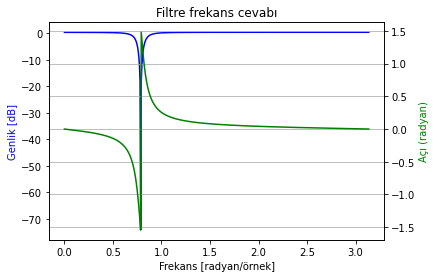

In [ ]:
# Sistemin a ve b katsayı vektörleri/dizileri ile tanımı
b = [1, -1.4142, 1] # üstteki polinomun katayıları
a = [1, -1.3433, 0.9025] # alttaki polinomun katayıları

# Sistemin frekans cevabının çizdirilmesi
plot_freqz(b, a)

Şekil 2.27: *Sistemin frekans cevabı*

Sistemin dürtü cevabını oluşturmak istersek $\delta[n]$ girdiye karşılık çıktıyı sistemi uygulayarak oluşturabiliriz: 

Text(0, 0.5, 'h[n]')

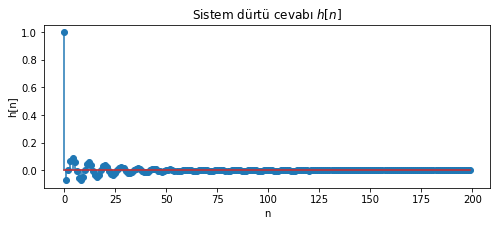

In [ ]:
N = 200 # Sinyal uzunluğu
delta_n = np.zeros((N,))
delta_n[0] = 1

# Sistemin uygulanması
h_n = signal.lfilter(b, a, delta_n) # b ve a sistemi tanımlıyor, delta_n ise girdi sinyali

fig = plt.figure(figsize=(8,3))
plt.stem(h_n);plt.title('Sistem dürtü cevabı $h[n]$');plt.xlabel('n');plt.ylabel('h[n]')

Şekil 2.28: *Sistemin dürtü cevabı*

Dürtü cevabının spektrumunu çizdirip yukarıdaki frekans cevabıyla benzerliğini kontrol edebiliriz. Aynı cevabı elde etmeyi bekliyoruz.

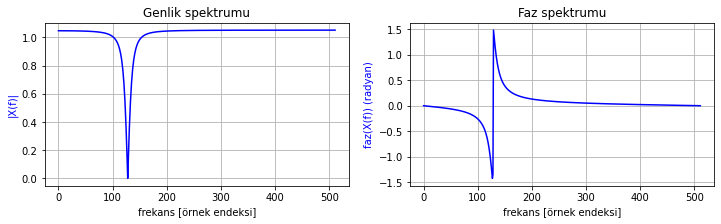

In [ ]:
frekans_cevabi_cizdir(h_n)

Şekil 2.29: *Sistemin dürtü cevabının Fourier dönüşümünden elde edilen sistem frekans cevabı*

### Egzersiz/örnek 2

Aşağıdaki denklemle tanımlanan sistemin frekans cevabını çizdiriniz:

$$H(e^{j\omega}) = \frac{1-e^{-j2\omega}}{1-0.25e^{-j\omega}}$$

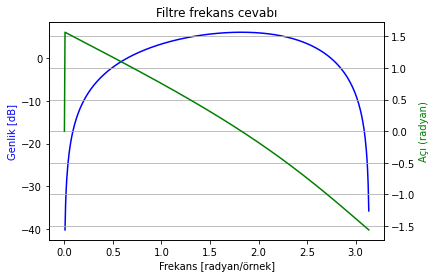

In [ ]:
# Polinomları doğru şekilde tanımlayıp fonksiyonu kullanmak yeterli olacaktır
b = [1, 0, -1] # dikkat: polinomda 1. derece üst çapranı sıfır
a = [1, 0.25]
plot_freqz(b, a)

Şekil 2.30: *Sistem frekans cevabı*

### Egzersiz/örnek 3

**Ters sistemler** Aşağıdaki iki sistem birbirinin tersidir. Frekans cevaplarını çizdirerek kontrol ediniz:

$$H(e^{j\omega}) = \frac{1-0.25e^{-j\omega}}{1+0.5e^{-j\omega}}$$

$$G(e^{j\omega}) = \frac{1+0.5e^{-j\omega}}{1-0.25e^{-j\omega}}$$

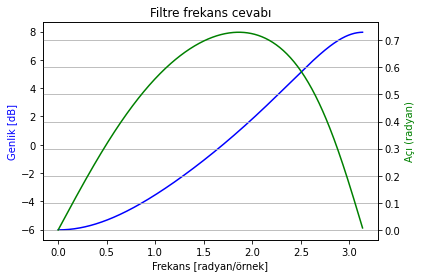

In [ ]:
h_b = [1, -0.25]
h_a = [1, 0.5]
plot_freqz(h_b, h_a)

Şekil 2.31: *Sistem frekans cevabı (H)*

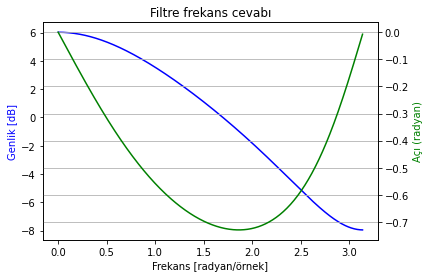

In [ ]:
g_a = h_b;g_b = h_a
plot_freqz(g_b, g_a)

Şekil 2.32: *Sistem frekans cevabı (G)*

Şekil 2.31 ve 2.32'yi karşılaştırdığımızda sistemin frekans cevaplarının birbirinin tersi olduğunu görebiliyoruz.

### Egzersiz/örnek 4

Aşağıdaki denklem ile tanımlanmış sistemin frekans cevabını çizdiren bir kod parçası yazınız:

$y[n]+0.5y[n-1]+0.75y[n-2]=x[n]-0.5x[n-1]+x[n-3]$

Fark denkleminden yola çıkarak transfer fonksiyonunu yazabiliriz: 

$$H(e^{j\omega}) = \frac{1-0.5e^{-j\omega}+e^{-j3\omega}}{1+0.5e^{-j\omega}+0.75e^{-j2\omega}}$$

Şimdi polinom katsayılarını taşıyan vektörleri oluşturup frekans cevabını çizdirelim.

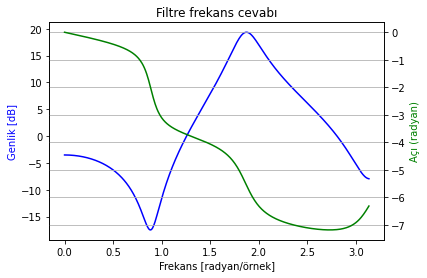

In [ ]:
h_b = [1, -0.5, 0, 1]
h_a = [1, 0.5, 0.75]
plot_freqz(h_b, h_a)

Şekil 2.33: *Sistem frekans cevabı*

### Egzersiz/örnek 5

Bir sinyal alttaki sistemle filtrelenmiştir: 
$$y[n] - 0.8 y[n-1] = x[n]$$

Filtrenin etkisini düzeltecek bir sistem tasarlayıp gerçekleyiniz.

Soru kaynakça: 
https://ethz.ch/content/dam/ethz/special-interest/mavt/dynamic-systems-n-control/idsc-dam/Lectures/Signals-and-Systems/ProblemSets/nProblemSet4.pdf
(Problem 9)

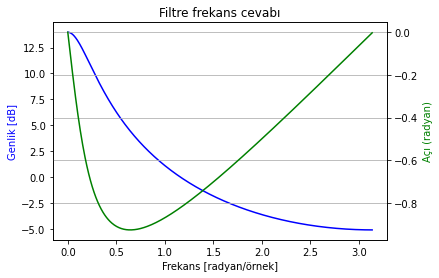

In [ ]:
# Verilen sistemin frekans cevabının çizdirilmesi
h_b = [1]
h_a = [1, -0.8]
plot_freqz(h_b, h_a)

Şekil 2.34: *Sistem frekans cevabı*


$$y[n] = x[n] - 0.8 x[n-1]$$

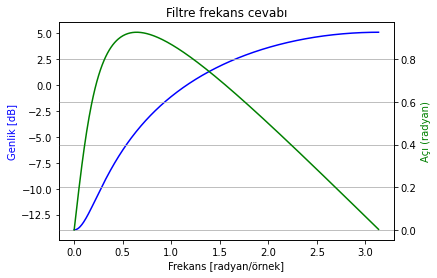

In [ ]:
# Sistemin tersini oluşturmak için polinomların yer değiştirmesi yeterli
h_b_ters = h_a
h_a_ters = h_b
plot_freqz(h_b_ters, h_a_ters)

Şekil 2.35: *Sistemin tersi olan sistemin frekans cevabı*


Sistemlerin birbirinin tersi olduğunu kontrol etmek için ilkinin dürtü cevabını ikinci sistem ile filtreleyebiliriz. Sonuç $\delta[n]$ ise sistemler birbirinin tersidir. Bu testi daha önce integral ve fark sistemlerinin birbirinin tersi olduğunu doğrulamak için uygulamıştık.

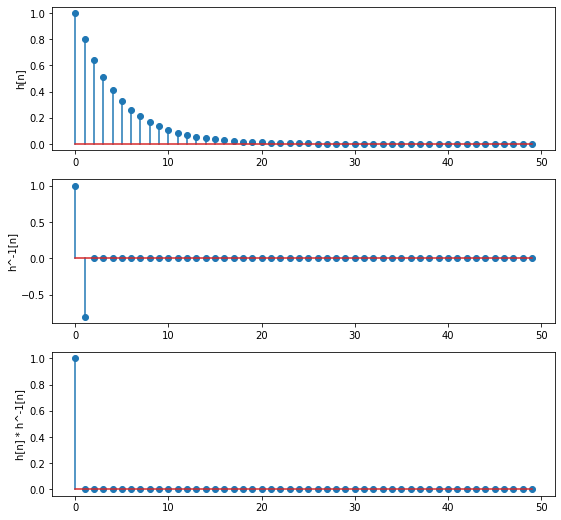

In [ ]:
N = 50
delta_n = np.zeros((N,))
delta_n[0] = 1

# Sistemin dürtü cevabının oluşturulması
h1_n = signal.lfilter(h_b, h_a, delta_n)

# Sistemin dürtü cevabının ters filtre ile filtrelenmesi
y_n = signal.lfilter(h_b_ters, h_a_ters, h1_n)

fig = plt.figure(figsize=(9,9))
plt.subplot(3,1,1)
plt.stem(h1_n);plt.ylabel('h[n]')
plt.subplot(3,1,2)
plt.stem(signal.lfilter(h_b_ters, h_a_ters, delta_n));plt.ylabel('h^-1[n]')
plt.subplot(3,1,3)
plt.stem(y_n);plt.ylabel('h[n] * h^-1[n]');

Şekil 2.36: *Verilen iki sistemin biribirinin tersi olduğunun dürtü cevapları üzerinden doğrulanması*

Bu defterimizde sayısal sistemlere örnekler sunduk. Sistemleri gerçeklerken kullanılabilecek üç farklı yaklaşımı ele aldık. Ayrıca sistemlerin spektrumlarını da (yüzeysel de olsa) incelemeye başlamış olduk. Filtre örnekleri olarak bazı FIR filtreler tasarlayıp kullandık. Bir sonraki defterimizde sistemlerin frekans cevaplarını ele almaya başlayacağız.

**Yazar:** Barış Bozkurt, **editör:** Ahmet Uysal

---